### Imports

In [1]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [2]:
buy_threshold = 0.1
sell_threshold = 0.1
starting_balance = 1000000
price_cap_lower = 2
investment_ratio = 0.00005
long_short_ratio = 0.05

run_optimizing = True
google_colab = False

### Data loading

In [3]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1PZQLyOiOpKtLt5BVAvWwQEnxZJzvLcD7"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Full trading data - All models.csv')  
    df = pd.read_csv('Full trading data - All models.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/trading/Full trading data - All models.csv')

In [4]:
# Drop Expire_date column
df.drop('Expire_date', axis=1, inplace=True)

In [5]:
# Filter so its just data for 2015
#df = df[(df["Quote_date"] >= "2015-01-01") & (df["Quote_date"] <= "2018-12-31")]
#df = df[(df["Expiry_date"] >= "2015-01-01") & (df["Expiry_date"] <= "2018-12-31")]

# Choos 5% of the data randomly
#df = df.sample(frac=0.05, random_state=1)

In [6]:
lstm_mlp = True
bs_rolling = False
bs_garch = False
bs_iv = False
heston = False

if lstm_mlp:
    # Out of Quote_date	Expire_date	Price	Bid	Ask	Underlying_last	Strike	TTM	Delta	IV	R	Price_drop	Rolling	GARCH	BS-IV	Heston	LSTM-MLP, drop Rolling, GARCH, BS-IV, Heston
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'LSTM-MLP']]
    # Rename LSTM-MLP to Prediction
    df = df.rename(columns={'LSTM-MLP': 'Prediction'})
elif bs_rolling:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Rolling']]
    df = df.rename(columns={'Rolling': 'Prediction'})
elif bs_garch:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'GARCH']]
    df = df.rename(columns={'GARCH': 'Prediction'})
elif bs_iv:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'BS-IV']]
    df = df.rename(columns={'BS-IV': 'Prediction'})
elif heston:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Heston']]
    df = df.rename(columns={'Heston': 'Prediction'})

### Data processing

In [7]:
df["TTM"] = (df["TTM"]*365).astype(int)

In [8]:
print(len(df))

437969


# Trading functions

In [9]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Ask']) / df['Ask'] >= buy_threshold
    sell_signal = (df['Bid'] - df['Prediction']) / df['Bid'] >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio = 0.002, long_short_ratio= 0.02, fee = 0.001):
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000    # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    total_balance_dict = {first_date: starting_balance}

    number_of_long_positions = 0
    number_of_short_positions = 0

    def operation(row):
        nonlocal number_of_long_positions
        nonlocal number_of_short_positions
        if row['Quote_date'] not in total_balance_dict.keys():
            total_balance_dict[row['Quote_date']] = total_balance_dict[max(total_balance_dict.keys())]

        balance = total_balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        # If price below cap, do nothing
        if row["Price"] < price_cap_lower:
            row["Position_this_opt"] = position
            row["Balance"] = balance
            position_dict[row['Option_ID']] = position
            total_balance_dict[row['Quote_date']] = balance
            return row

        # Calculate net ratio
        if number_of_long_positions + number_of_short_positions == 0:
            net_ratio = 0
        else:
            net_ratio = (number_of_long_positions - number_of_short_positions) / (number_of_long_positions + number_of_short_positions)

        # Buy 
        if row['Signal'] == 1 and position <= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio < long_short_ratio:
            amount_to_invest = balance * investment_ratio
            if amount_to_invest <= balance:
                balance -= amount_to_invest * (1 + fee)
                position += amount_to_invest / row['Ask']
                number_of_long_positions += 1

        # Sell
        elif row['Signal'] == -1 and position >= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio > -long_short_ratio:
            amount_to_sell = balance * investment_ratio
            balance += amount_to_sell * (1 - fee)
            position -= amount_to_sell / row['Bid']
            number_of_short_positions += 1


        # Expire
        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position > 0 else -intrinsic_value
            balance += adjustment * abs(position)
            position = 0
            if position < 0:
                number_of_short_positions -= 1
            elif position > 0:
                number_of_long_positions -= 1
        
        
        row['Position_this_opt'] = position
        position_dict[row['Option_ID']] = position
        total_balance_dict[row['Quote_date']] = balance
        row['Balance'] = balance

        # Print progress
        if row.name % 100000 == 0:
            print(row["Quote_date"])
            print("Number of long positions: ", number_of_long_positions)
            print("Number of short positions: ", number_of_short_positions)
            print("Balnace: ", balance)
        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(total_balance_dict)
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    for date in df['Quote_date'].unique():
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Analysis functions

In [10]:
def sharpe_ratio(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Excess_Returns'] = df_group['Total_value'].pct_change() - 0.02 / 252
    sharpe_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group["Excess_Returns"].std())
    return sharpe_ratio

In [11]:
def sharpe_ratio_monthly(df):
    df_sharpe = df.copy()
    # Get YYYY-MM for each row
    df_sharpe["YYYY-MM"] = df_sharpe["Quote_date"].dt.strftime("%Y-%m")
    df_sharpe = df_sharpe.groupby("YYYY-MM").last()
    df_sharpe["Excess_Returns"] = df_sharpe["Total_value"].pct_change() - 0.02 / 12
    sharpe_ratio = np.sqrt(12) * (df_sharpe["Excess_Returns"].mean() / df_sharpe["Excess_Returns"].std())
    return sharpe_ratio 

In [12]:
def capm_alpha(df_capm):
    # Find alpha in the CAPM model using linear regression and grouping df by Quote_date, then taking the alpha of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.intercept_[0] * 252

In [13]:
def capm_beta(df_capm):
    # Find beta in the CAPM model using linear regression and grouping df by Quote_date, then taking the beta of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0][0] * 252

In [14]:
def max_drawdown(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Roll_Max'] = df_group['Total_value'].cummax()
    df_group['Drawdown'] = df_group['Total_value'] / df_group['Roll_Max'] - 1.0
    df_group['Drawdown'].min()
    return df_group['Drawdown'].min() * 100

In [15]:
def print_results(df, starting_balance):
    ending_balance = df['Balance'].iloc[-1]
    profit = ending_balance - starting_balance
    num_trades = df[df["Price"] > 1]["Signal"].abs().sum()
    profit_per_trade = profit / num_trades

    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    trading_days = df['Quote_date'].unique().shape[0] - 1
    profit_per_day = profit / trading_days
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

    print(f"Starting balance: {starting_balance}")
    print(f"Ending balance: {ending_balance.round(0)}")
    print(f"Profit: {profit.round(0)}")
    print(f"Profit per trade: {profit_per_trade.round(2)}")
    print(f"Profit per trading day: {profit_per_day.round(2)}")
    print(f"Sharpe ratio: {sharpe_ratio_monthly(df).round(2)}")
    print(f"CAPM alpha: {capm_alpha(df).round(2)}")
    print(f"Annualized return in percent: {annualized_return.round(2)}")
    print(f"Max drawdown: {max_drawdown(df).round(2)}")

In [16]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Cash')
    plt.plot(df['Options_value'], label='Net value of options')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Run the code

In [17]:
def get_table(df, starting_balance, price_cap_lower, investment_ratio, long_short_ratio, buy_threshold, sell_threshold):
    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=["Year", "Starting balance", "Ending balance", "Profit", "Profit per trade", "Profit per trading day", 
                                    "Sharpe ratio", "CAPM alpha", "Annualized return in percent", "Max drawdown"])

    # Get the list of years present in the data
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    years = df['Quote_date'].dt.year.unique()

    # Sort the years
    years.sort()

    # Iterate over each year
    for year in years:
        df_year = df[df['Quote_date'].dt.year == year].copy()
        
        if not df_year.empty:
            # Execute operations
            buy_signal, sell_signal = generate_buy_sell_signals(df_year, buy_threshold, sell_threshold=buy_threshold) # Same buy and sell threshold
            df_year = trader(df_year, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio)
            df_year = calculate_options_value(df_year)

            # Calculate metrics
            ending_balance = df_year['Balance'].iloc[-1]
            profit = ending_balance - starting_balance
            num_trades = df_year[df_year["Price"] > 1]["Signal"].abs().sum()
            profit_per_trade = profit / num_trades

            trading_days = df_year['Quote_date'].unique().shape[0] - 1
            profit_per_day = profit / trading_days
            num_days = (df_year['Quote_date'].max() - df_year['Quote_date'].min()).days

            annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

            plot(df_year)

            # Create a DataFrame for this year's metrics
            year_metrics = pd.DataFrame({
                "Year": [year], 
                "Starting balance": [starting_balance], 
                "Ending balance": [ending_balance.round(0)], 
                "Profit": [profit.round(0)], 
                "Profit per trade": [profit_per_trade.round(2)], 
                "Profit per trading day": [profit_per_day.round(2)], 
                "Sharpe ratio": [sharpe_ratio_monthly(df_year).round(2)], 
                "CAPM alpha": [capm_alpha(df_year).round(2)], 
                "Annualized return in percent": [annualized_return.round(2)], 
                "Max drawdown": [max_drawdown(df_year).round(2)]
            })

            # Add metrics to the results DataFrame
            results = pd.concat([results, year_metrics])

    # Reset index of the results DataFrame
    results.reset_index(drop=True, inplace=True)

    # Print the results DataFrame
    print(results)

    # Return average sharpe ratio, alpha and annualized return
    return results["Sharpe ratio"].mean(), results["CAPM alpha"].mean(), results["Annualized return in percent"].mean(), results["Ending balance"].mean(), 

### Post analysis

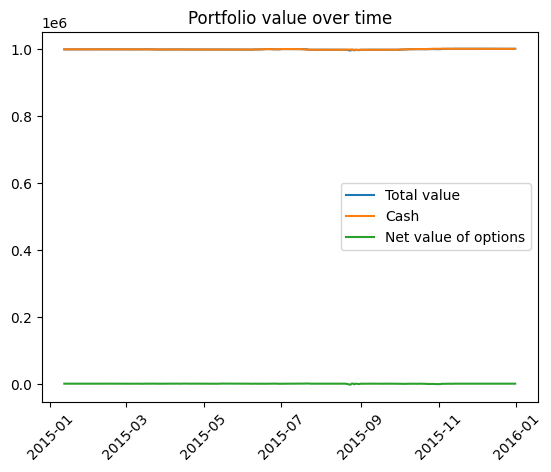

2016-02-18 00:00:00
Number of long positions:  113
Number of short positions:  125
Balnace:  1000842.2092450196


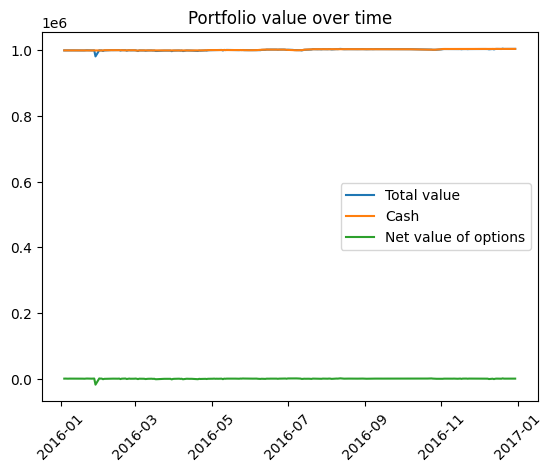

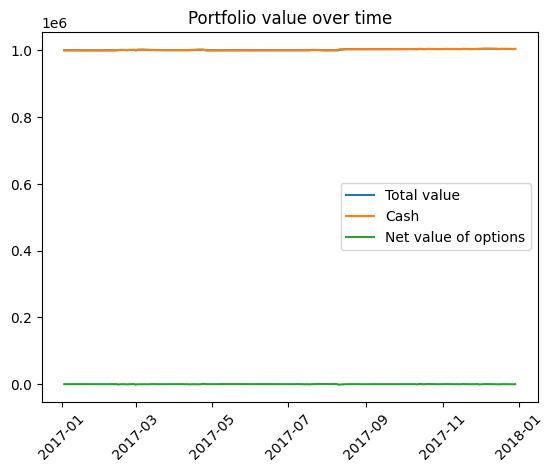

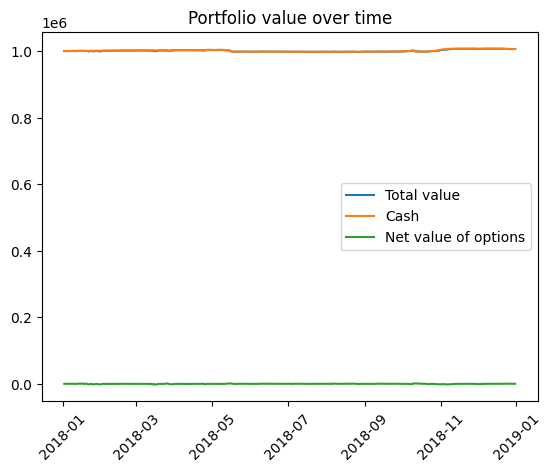

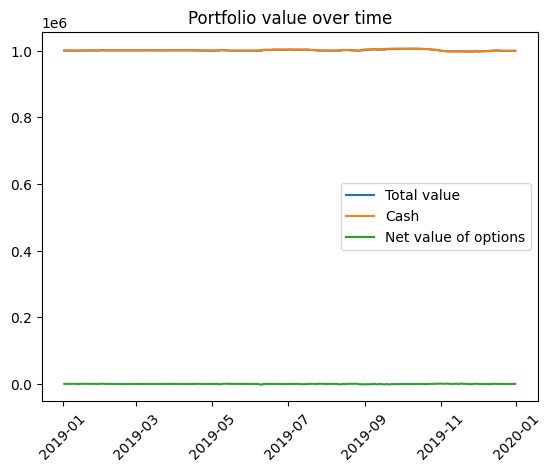

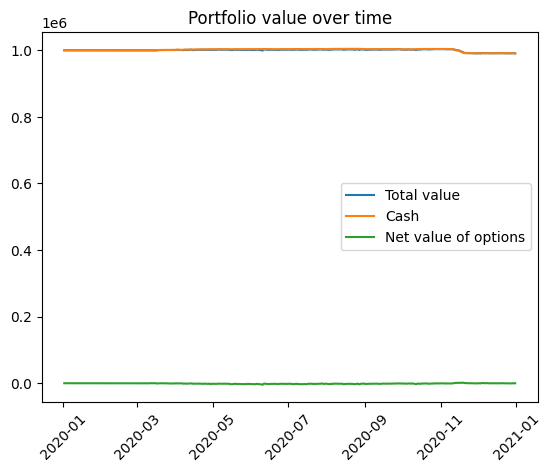

2021-07-08 00:00:00
Number of long positions:  1087
Number of short positions:  1021
Balnace:  996185.0954773256


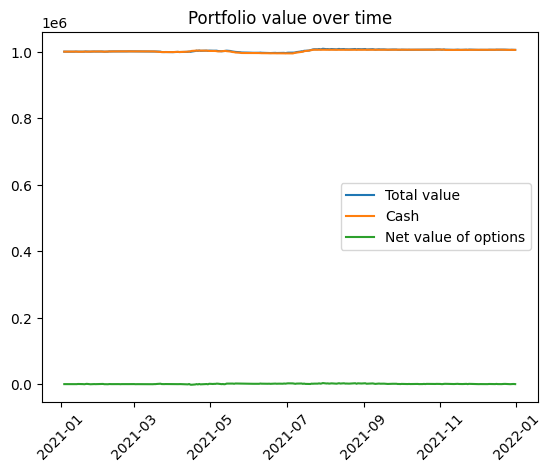

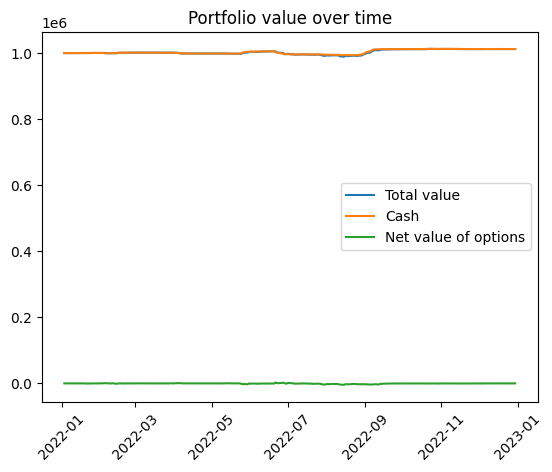

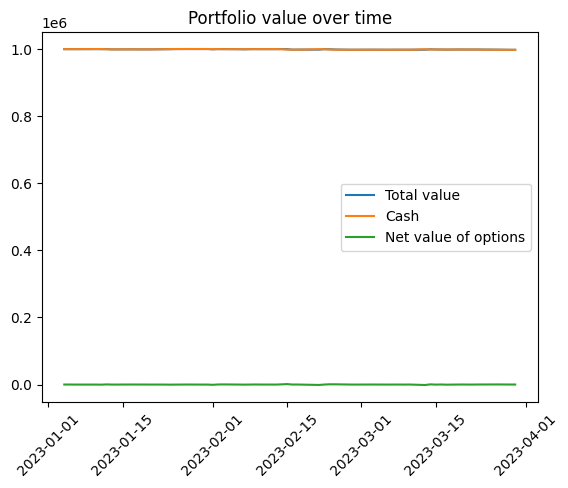

   Year Starting balance  Ending balance   Profit  Profit per trade   
0  2015          1000000       1001594.0   1594.0              0.36  \
1  2016          1000000       1004573.0   4573.0              1.37   
2  2017          1000000       1004044.0   4044.0              0.81   
3  2018          1000000       1006122.0   6122.0              0.72   
4  2019          1000000        999267.0   -733.0             -0.13   
5  2020          1000000        990686.0  -9314.0             -0.93   
6  2021          1000000       1005292.0   5292.0              0.54   
7  2022          1000000       1012203.0  12203.0              0.68   
8  2023          1000000        997915.0  -2085.0             -1.29   

   Profit per trading day  Sharpe ratio  CAPM alpha   
0                    6.51         -5.33        0.00  \
1                   18.29          0.27        0.01   
2                   16.24         -4.01        0.01   
3                   24.39         -1.45        0.01   
4             

In [18]:
sharpe_ratio, alpha, annualized_return = get_table(df, starting_balance, price_cap_lower, investment_ratio, long_short_ratio, buy_threshold, sell_threshold)
print(f"Average sharpe ratio: {sharpe_ratio.round(2)}")
print(f"Average CAPM alpha: {alpha.round(2)}")
print(f"Average annualized return in percent: {annualized_return.round(2)}")

In [17]:
if run_optimizing == False:
    plot(df)

## Threshold search

In [18]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': '2015-2023 - Average - v13',
    'metric': {
        'goal': 'maximize', 
        'name': 'alpha'
        },
    'parameters': {
        'buy_sell_threshold': {
            'values': [0.01, 0.02, 0.5, 0.1]},
        'price_cap_lower': {
            'values': [0.5, 1]},
        'investment_ratio': {
            'values': [1e-5, 5e-5, 1e-4]},
        'long_short_ratio': {
            'values': [0.05, 0.1]}
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vinje (avogadro). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/hjalmarjacobvinje/.netrc


Create sweep with ID: 0wrlbk6b
Sweep URL: https://wandb.ai/avogadro/options-trading/sweeps/0wrlbk6b


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<IPython.core.display.HTML object>


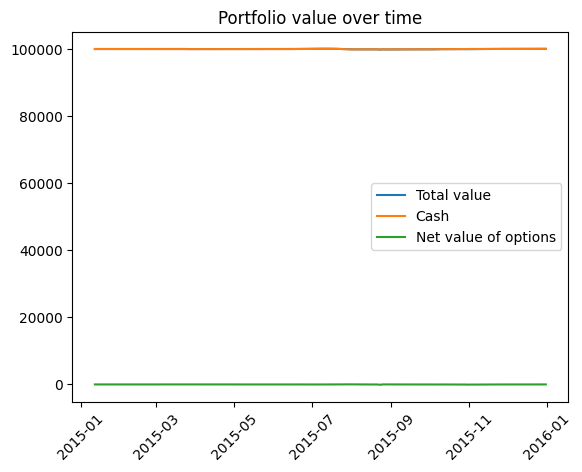

2016-02-18 00:00:00
Number of long positions:  237
Number of short positions:  290
Balnace:  100058.89260871985
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


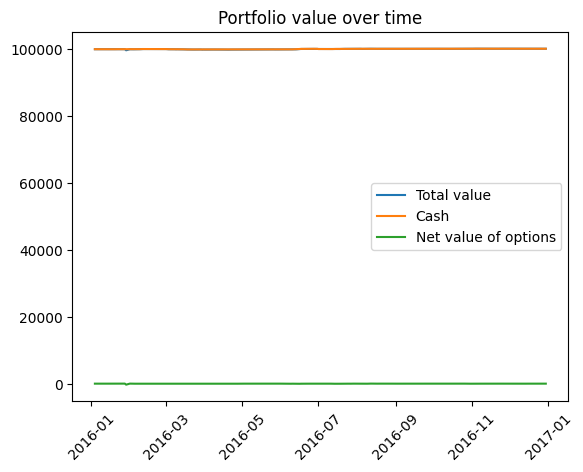

wandb: Agent Starting Run: i8xbu7zx with config:
wandb: 	buy_sell_threshold: 0.06
wandb: 	investment_ratio: 1e-05
wandb: 	long_short_ratio: 0.1
wandb: 	price_cap_lower: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 917, in run
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hjalmarjacobvinje/Documents/deep-learning-for-option-pricing/.venv/lib/python3.9/site-packag

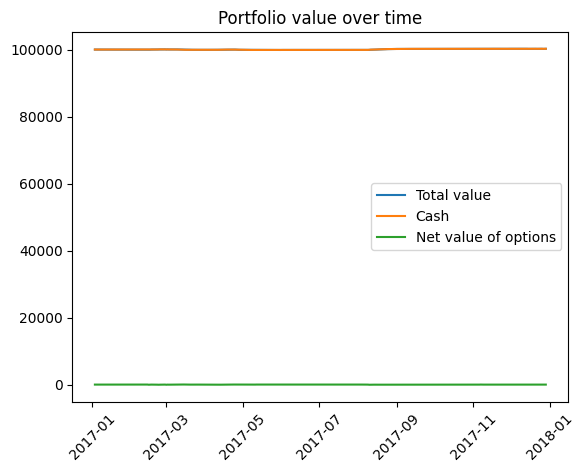

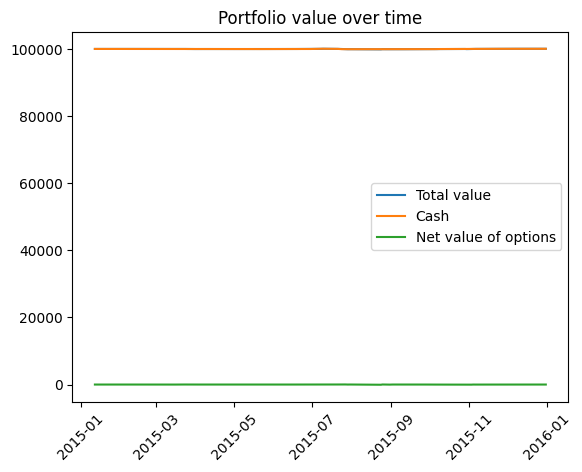

2016-02-18 00:00:00
Number of long positions:  182
Number of short positions:  223
Balnace:  100045.85544242755


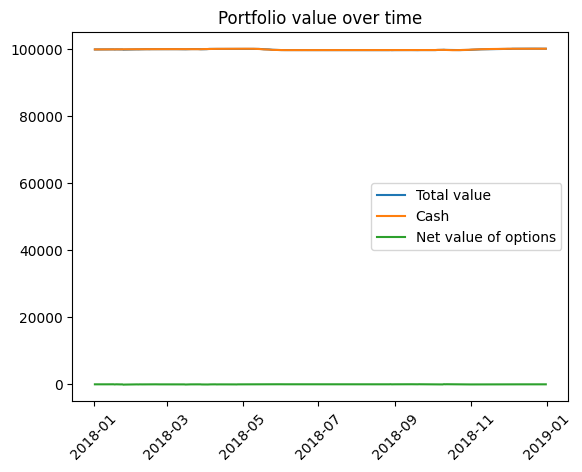

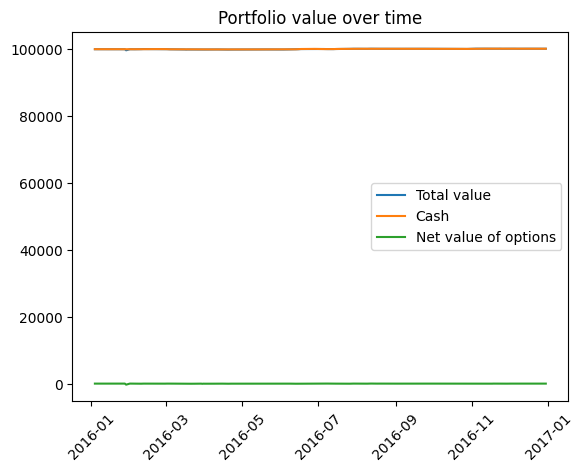

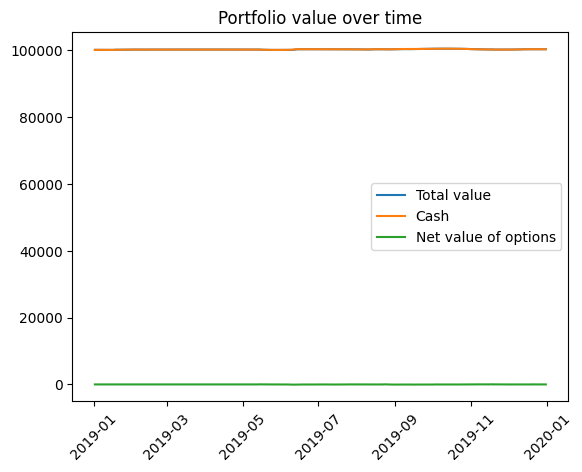

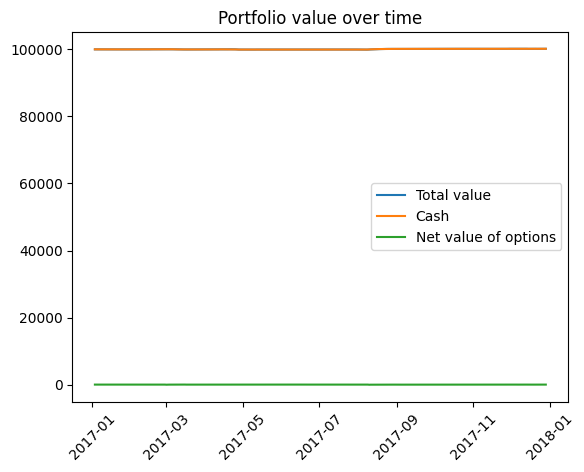

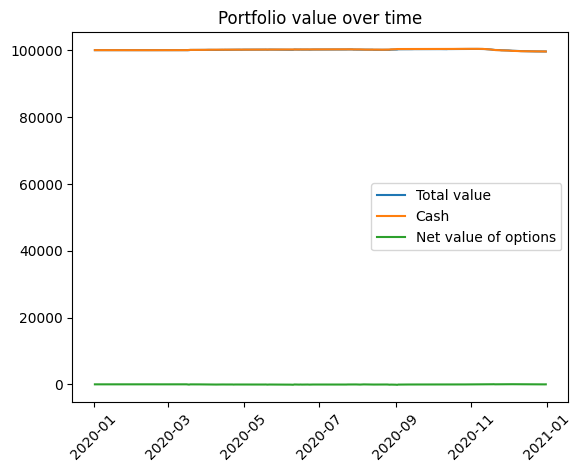

2021-07-08 00:00:00
Number of long positions:  1868
Number of short positions:  1780
Balnace:  99884.05324575058


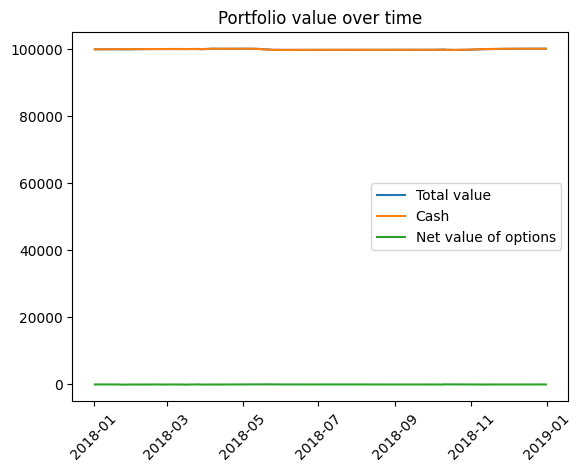

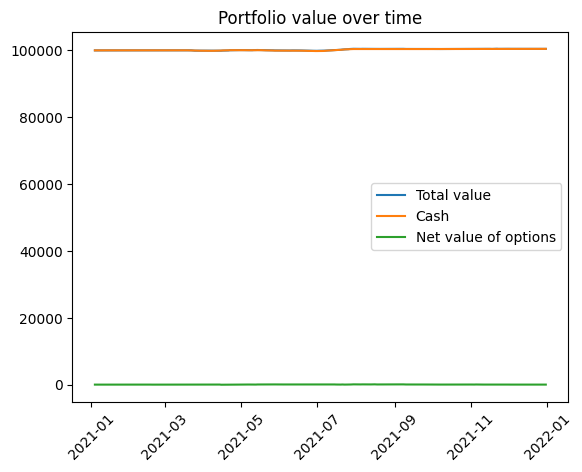

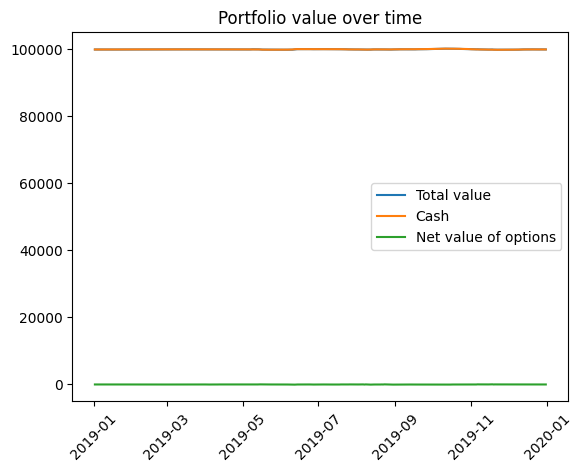

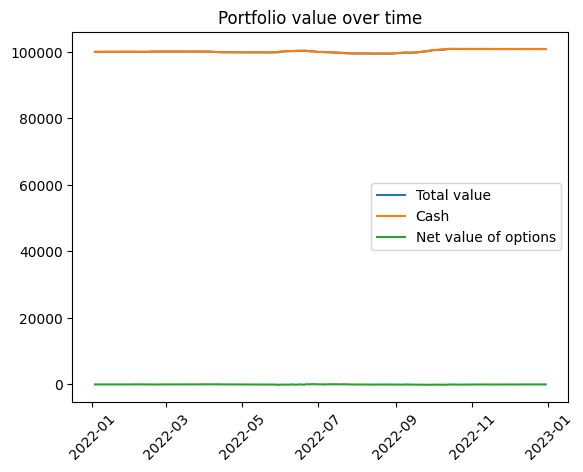

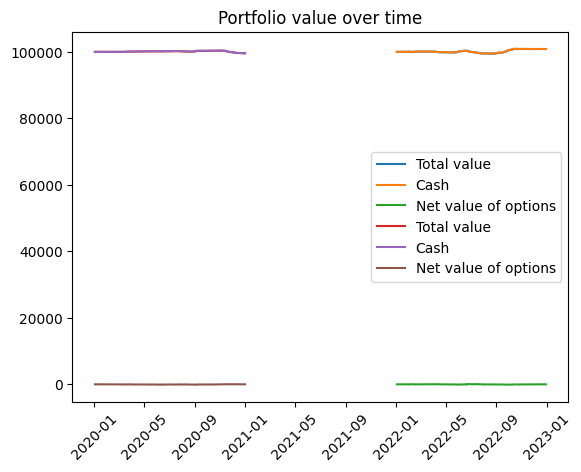

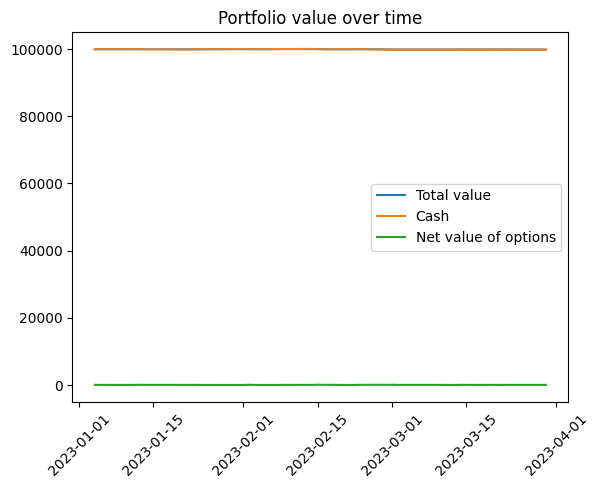

   Year Starting balance  Ending balance  Profit  Profit per trade   
0  2015           100000        100052.0    52.0              0.01  \
1  2016           100000        100143.0   143.0              0.03   
2  2017           100000        100229.0   229.0              0.04   
3  2018           100000        100215.0   215.0              0.02   
4  2019           100000        100188.0   188.0              0.03   
5  2020           100000         99599.0  -401.0             -0.03   
6  2021           100000        100459.0   459.0              0.03   
7  2022           100000        100848.0   848.0              0.04   
8  2023           100000         99886.0  -114.0             -0.05   

   Profit per trading day  Sharpe ratio  CAPM alpha   
0                    0.21        -10.43        0.00  \
1                    0.57         -3.45        0.00   
2                    0.92         -5.15        0.00   
3                    0.86         -3.24        0.00   
4                    0.7

2021-07-08 00:00:00
Number of long positions:  1815
Number of short positions:  1577
Balnace:  99765.36894536746


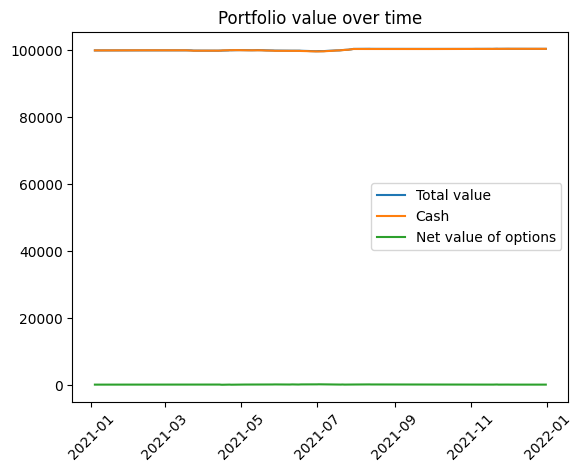

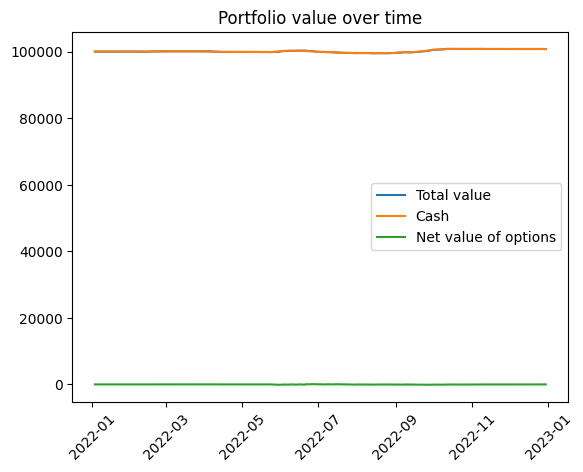

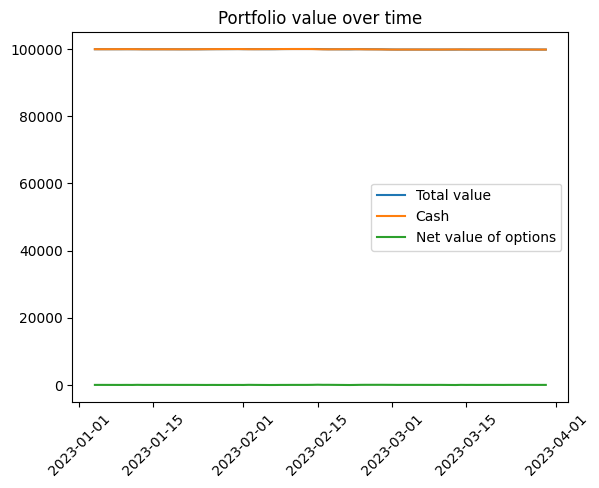

wandb: ERROR Run i8xbu7zx errored: KeyError('Balance')


   Year Starting balance  Ending balance  Profit  Profit per trade   
0  2015           100000        100045.0    45.0              0.01  \
1  2016           100000        100140.0   140.0              0.03   
2  2017           100000        100169.0   169.0              0.03   
3  2018           100000        100175.0   175.0              0.02   
4  2019           100000        100015.0    15.0              0.00   
5  2020           100000         99580.0  -420.0             -0.03   
6  2021           100000        100471.0   471.0              0.03   
7  2022           100000        100768.0   768.0              0.03   
8  2023           100000         99893.0  -107.0             -0.05   

   Profit per trading day  Sharpe ratio  CAPM alpha   
0                    0.19        -15.58        0.00  \
1                    0.56         -3.60        0.00   
2                    0.68         -8.99        0.00   
3                    0.70         -3.56        0.00   
4                    0.0

wandb: Agent Starting Run: 72y4j3hq with config:
wandb: 	buy_sell_threshold: 0.06
wandb: 	investment_ratio: 5e-05
wandb: 	long_short_ratio: 0.05
wandb: 	price_cap_lower: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


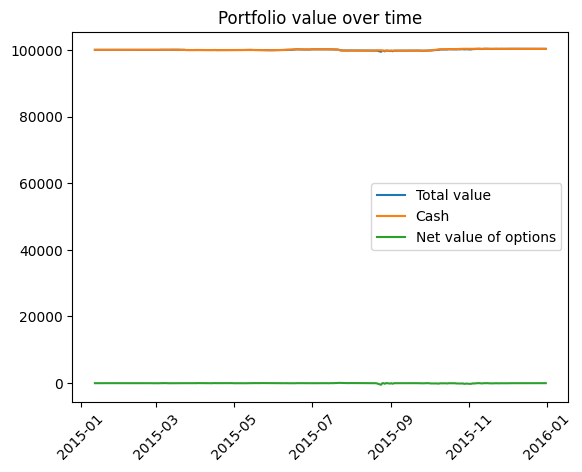

2016-02-18 00:00:00
Number of long positions:  204
Number of short positions:  226
Balnace:  100139.92696892525


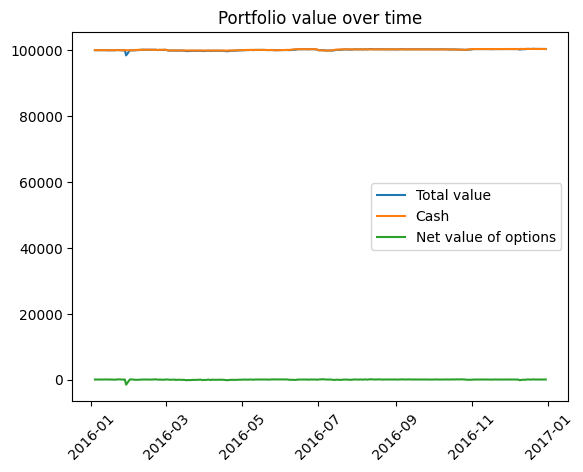

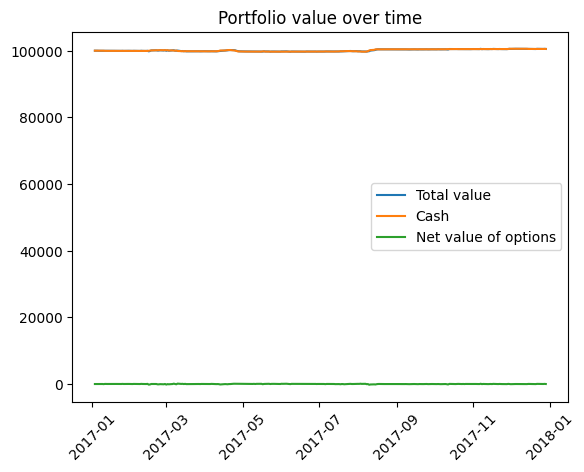

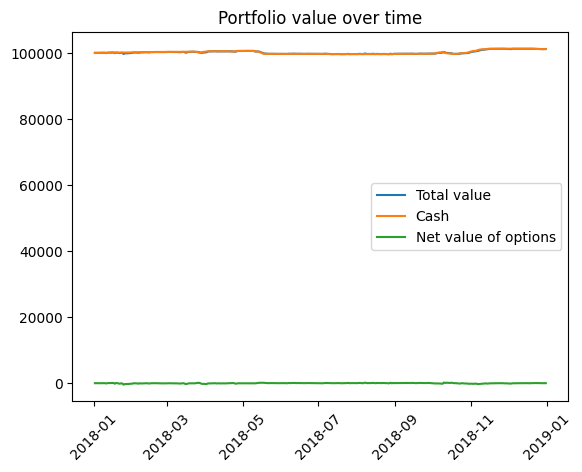

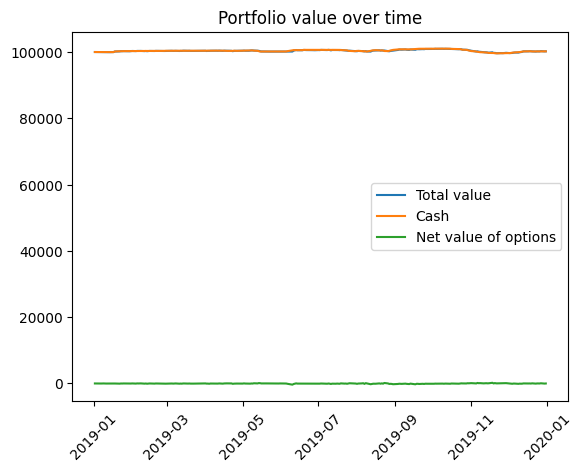

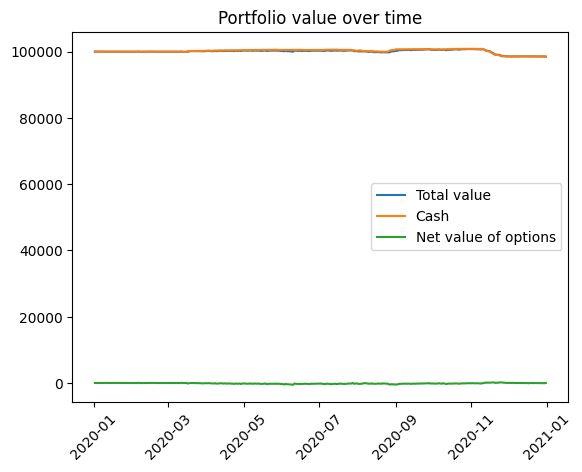

2021-07-08 00:00:00
Number of long positions:  1791
Number of short positions:  1697
Balnace:  99312.31052497696


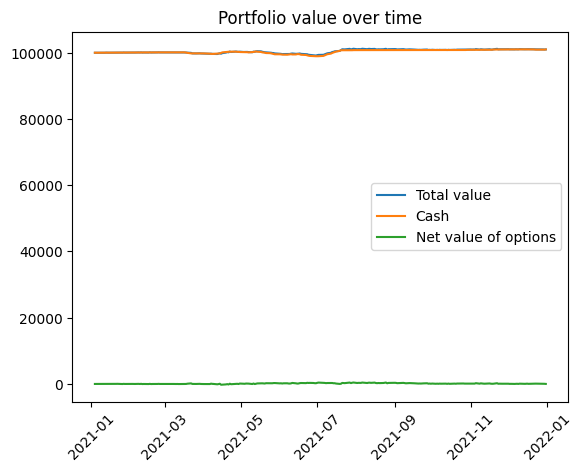

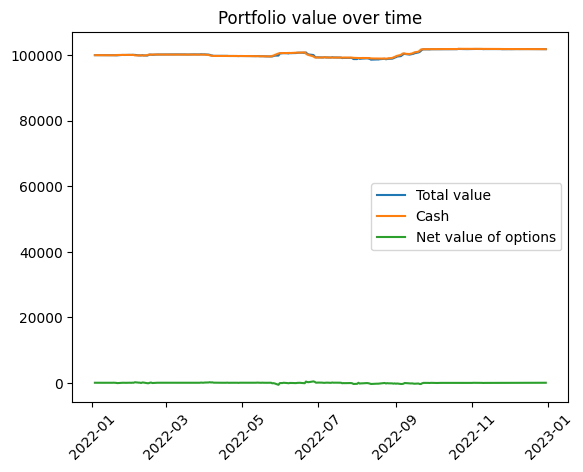

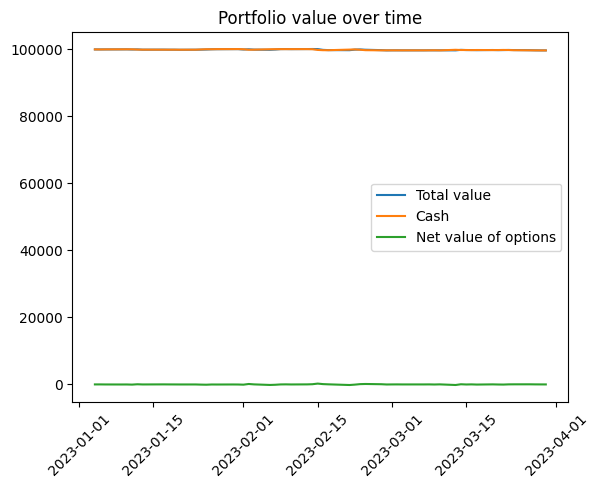

   Year Starting balance  Ending balance  Profit  Profit per trade   
0  2015           100000        100298.0   298.0              0.05  \
1  2016           100000        100359.0   359.0              0.08   
2  2017           100000        100518.0   518.0              0.08   
3  2018           100000        101160.0  1160.0              0.11   
4  2019           100000        100197.0   197.0              0.03   
5  2020           100000         98500.0 -1500.0             -0.11   
6  2021           100000        101002.0  1002.0              0.07   
7  2022           100000        101826.0  1826.0              0.08   
8  2023           100000         99702.0  -298.0             -0.14   

   Profit per trading day  Sharpe ratio  CAPM alpha   
0                    1.22         -2.52        0.00  \
1                    1.43          0.09        0.01   
2                    2.08         -1.99        0.01   
3                    4.62         -0.43        0.01   
4                    0.8

wandb: ERROR Run 72y4j3hq errored: KeyError('Balance')
wandb: Agent Starting Run: rvf6wdfs with config:
wandb: 	buy_sell_threshold: 0.06
wandb: 	investment_ratio: 5e-05
wandb: 	long_short_ratio: 0.05
wandb: 	price_cap_lower: 2
wandb: Ctrl + C detected. Stopping sweep.


Error in callback <function _WandbInit._pause_backend at 0x7f8c5a5bfb80> (for post_run_cell):


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


BrokenPipeError: [Errno 32] Broken pipe

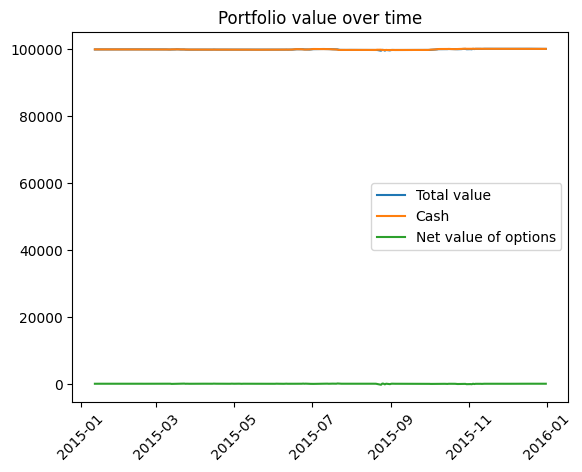

2016-02-18 00:00:00
Number of long positions:  155
Number of short positions:  172
Balnace:  100109.65301836828


In [ ]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        sharpe, alpha, annualized_return, ending_balance = get_table(df, 1000000, run.config.price_cap_lower, run.config.investment_ratio, run.config.long_short_ratio, run.config.buy_sell_threshold, run.config.buy_sell_threshold)
        run.log({"buy_threshold": run.config.buy_sell_threshold, "sharpe_ratio": sharpe, "ending_balance": ending_balance, "alpha": alpha, "long_short_ratio": run.config.long_short_ratio, "price_cap_lower": run.config.price_cap_lower, "investment_ratio": run.config.investment_ratio, "annualized_return": annualized_return})
        # Wandb callback
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)